# Import Libraries

In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import optuna

/home/mmostafa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Datasets

In [2]:
train_df = pd.read_csv("../data/pre_train.csv", index_col=0)
val_df = pd.read_csv("../data/pre_val.csv", index_col=0)
test_df = pd.read_csv("../data/pre_test.csv", index_col=0)

## Data Windowing

The models will make a set of predictions based on a window of consecutive samples from the data.

So, we will create Dataset Class that will be responsible for splitting the data into windows.

We will make the dataset adapt to the type of model we want to train (multi-output or single-output) by changing the `label_columns` parameter.

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        label_column: str = "Temp",
        input_width: int = 1,
        output_width: int = 1,
        shift: int = 1,
    ):
        self.data_df = data
        self.data = data.to_numpy()
        self.input_width = input_width
        self.output_width = output_width
        self.shift = shift

        if label_column:
            self.label_column_idx = data.columns.get_loc(label_column)
        else:
            self.label_column_idx = slice(None)

    def __len__(self):
        return (
            self.data.shape[0] - (self.input_width + self.output_width + self.shift) + 1
        )

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = idx + self.input_width
        inputs = self.data[start_idx:end_idx]

        start_idx = end_idx + self.shift
        end_idx = start_idx + self.output_width
        labels = self.data[start_idx:end_idx, self.label_column_idx]
        return torch.from_numpy(inputs).to(torch.float), torch.from_numpy(labels).to(
            torch.float
        )

Create a function to plot the input features, label, and prediction over a batch.

In [4]:
def plot_windows(
    dataset: TimeSeriesDataset,
    inputs_batch: torch.tensor,
    labels_batch: torch.tensor,
    model: nn.Module = None,
    plot_column: str = "Temp",
    num_samples: int = 1,
):
    """Plot the features, Labels and predictions for a single batch created by the dataloader"""
    _, axes = plt.subplots(
        nrows=num_samples,
        ncols=1,
        figsize=(14, 3 * num_samples),
        sharex=True,
        sharey=True,
    )
    plot_col_index = dataset.data_df.columns.get_loc(plot_column)

    for i, ax in enumerate(np.array(axes).reshape(-1)):
        inputs = inputs_batch[i, ...]
        labels = labels_batch[i, ...]
        if model:
            with torch.no_grad():
                preds = model(inputs.unsqueeze(0))

        # Plotting the features labels
        ax.plot(
            range(dataset.input_width),
            inputs[:, plot_col_index],
            label="Input Feature Labels",
            marker=".",
        )
        # Plotting the true labels
        ax.scatter(
            range(
                dataset.input_width + dataset.shift,
                dataset.input_width + dataset.shift + dataset.output_width,
            ),
            labels,
            label="True Labels",
            marker="o",
            c="green",
        )
        if model:
            # Plotting the predicted labels
            ax.scatter(
                range(
                    dataset.input_width + dataset.shift,
                    dataset.input_width + dataset.shift + dataset.output_width,
                ),
                preds.squeeze(0).numpy(),
                label="Predictions",
                marker="x",
                color="orange",
            )
    plt.legend(loc="upper left")
    plt.show()

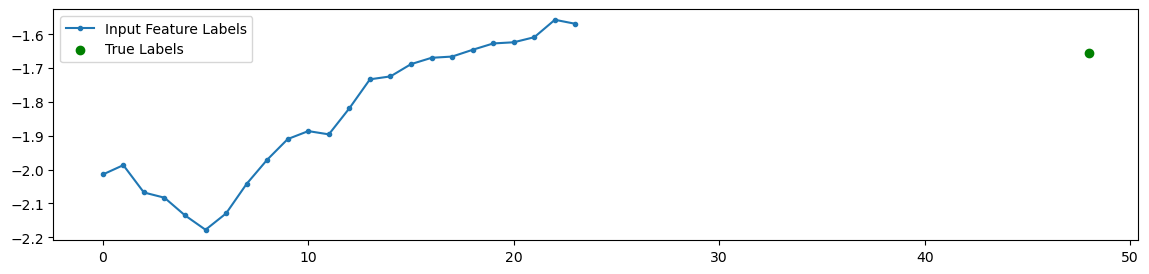

torch.Size([2, 24, 16]) torch.Size([2, 1])


In [5]:
# Try to plot the first batch of the training data
demo_dataset = TimeSeriesDataset(
    train_df, input_width=24, output_width=1, shift=24, label_column="Temp"
)
train_dataloader = DataLoader(demo_dataset, batch_size=2)

for inputs, labels in train_dataloader:
    plot_windows(demo_dataset, inputs, labels)
    print(inputs.shape, labels.shape)
    break

In [6]:
def train_model(
    model,
    train_loader: DataLoader,
    Criterion: torch.nn,
    Optimizer: torch.optim,
    num_epochs,
    lr=0.001,
):
    criterion = Criterion()
    optimizer = Optimizer(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")

In [7]:
def evaluate_model(model, test_loader, Criterion: torch.nn):
    criterion = Criterion()
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    average_loss = total_loss / len(test_loader)
    return average_loss, inputs, labels

## Shortlist Promising Models

### Multi-Step Single Shot Models

We build a model that takes in the last 24 hours of data, and predicts the next 24 hours.

<p align="center">
    <img src="https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_dense.png"/>
</p>


In [8]:
OUTPUT_SIZE = 24
INPUT_SIZE = 24
N_FEATURES = 16

In [9]:
train_dataset = TimeSeriesDataset(
    train_df,
    input_width=INPUT_SIZE,
    output_width=OUTPUT_SIZE,
    shift=1,
    label_column="Temp",
)
val_dataset = TimeSeriesDataset(
    val_df,
    input_width=INPUT_SIZE,
    output_width=OUTPUT_SIZE,
    shift=1,
    label_column="Temp",
)
test_dataset = TimeSeriesDataset(
    test_df,
    input_width=INPUT_SIZE,
    output_width=OUTPUT_SIZE,
    shift=1,
    label_column="Temp",
)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Baseline

We will use a simple Linear model as a baseline.

In [11]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        out = out[:, -1, :]
        return out


lr_model = LinearRegressionModel(N_FEATURES, OUTPUT_SIZE)

In [12]:
# Train the Linear Regression Model
train_model(lr_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=10)

Epoch: 0, Loss: 0.013249699957668781
Epoch: 1, Loss: 0.015550825744867325
Epoch: 2, Loss: 0.017665833234786987
Epoch: 3, Loss: 0.019053487107157707
Epoch: 4, Loss: 0.0199980977922678
Epoch: 5, Loss: 0.02063426561653614
Epoch: 6, Loss: 0.021053515374660492
Epoch: 7, Loss: 0.021325482055544853
Epoch: 8, Loss: 0.021501589566469193
Epoch: 9, Loss: 0.021616710349917412


In [13]:
lr_val_loss, inputs_sample, labels_sample = evaluate_model(
    lr_model, val_loader, nn.MSELoss
)

In [14]:
lr_val_loss

0.11109322535226167

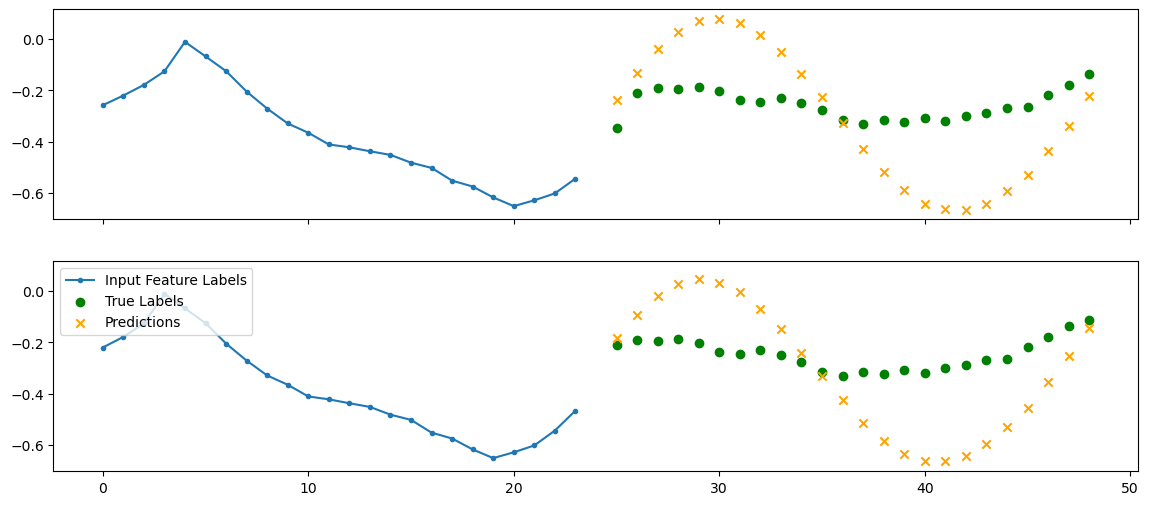

In [15]:
plot_windows(
    val_dataset,
    inputs_sample,
    labels_sample,
    model=lr_model,
    plot_column="Temp",
    num_samples=2,
)

#### GRU 

In [16]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Initialize the GRU model
gru_model = GRUModel(
    input_size=N_FEATURES, hidden_size=128, num_layers=2, output_size=OUTPUT_SIZE
)

In [17]:
# Training the GRU model
train_model(gru_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=5)

Epoch: 0, Loss: 0.02382289431989193
Epoch: 1, Loss: 0.028448713943362236
Epoch: 2, Loss: 0.03299223631620407
Epoch: 3, Loss: 0.039046354591846466
Epoch: 4, Loss: 0.04891438037157059


In [18]:
# Evaluate the GRU model on the validation set
gru_val_loss, sample_input, sample_label = evaluate_model(
    gru_model, val_loader, nn.MSELoss
)

In [19]:
gru_val_loss

0.09436935610024304

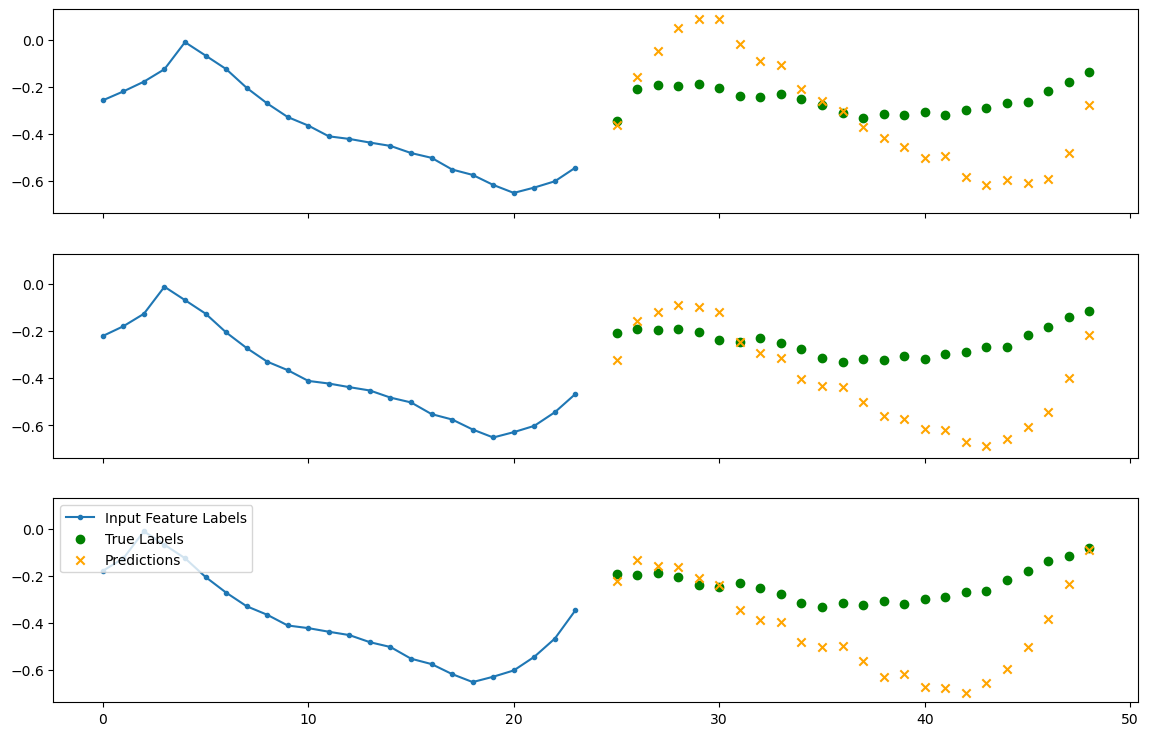

In [20]:
plot_windows(train_dataset, sample_input, sample_label, model=gru_model, num_samples=3)

#### LSTM

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out


# Create an instance of LSTM model
lstm_model = LSTMModel(
    input_dim=N_FEATURES, hidden_dim=128, layer_dim=2, output_dim=OUTPUT_SIZE
)

In [22]:
# Train the LSTM model
train_model(lstm_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=5)

Epoch: 0, Loss: 0.018898161128163338
Epoch: 1, Loss: 0.022489331662654877
Epoch: 2, Loss: 0.026570551097393036
Epoch: 3, Loss: 0.0289657823741436
Epoch: 4, Loss: 0.029219726100564003


In [23]:
# Evaluate the LSTM model on the validation set
lstm_val_loss, sample_input, sample_label = evaluate_model(
    lstm_model, val_loader, nn.MSELoss
)
lstm_val_loss

0.09269961523653077

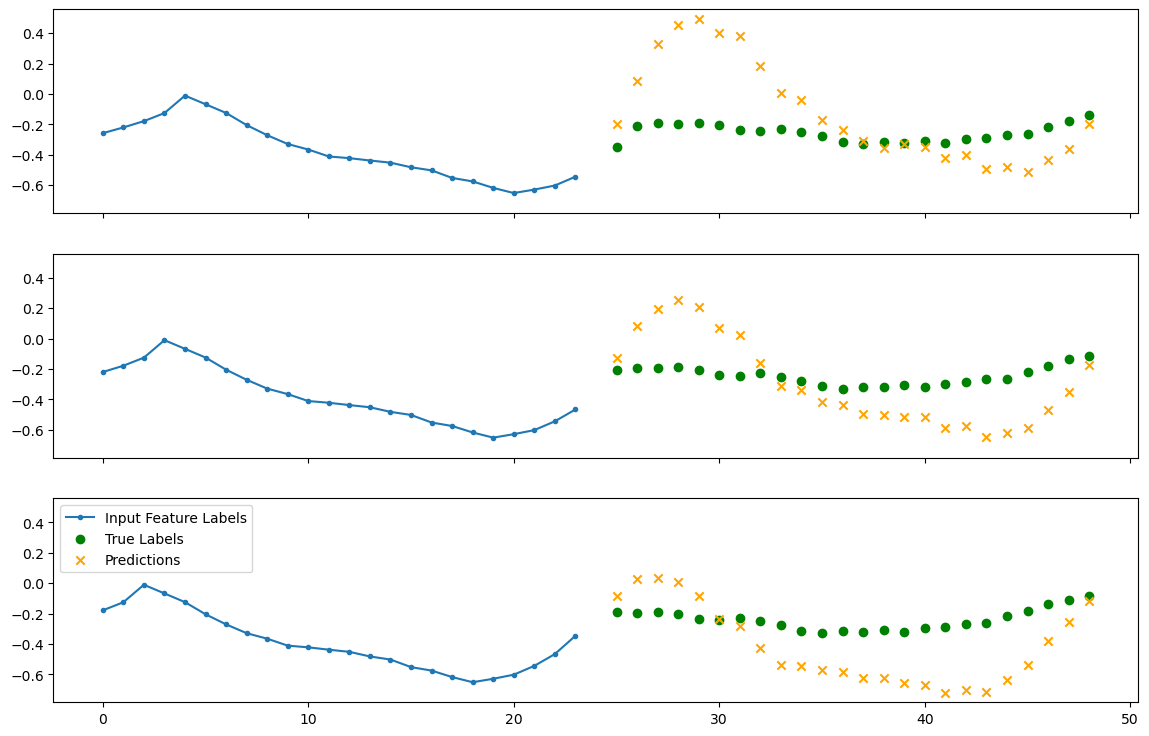

In [24]:
plot_windows(train_dataset, sample_input, sample_label, model=lstm_model, num_samples=3)

#### RNN 

In [25]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Create an instance of RNN model
rnn_model = RNNModel(input_dim=N_FEATURES, hidden_dim=128, output_dim=OUTPUT_SIZE)

In [26]:
# train the RNN model
train_model(rnn_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=5)

Epoch: 0, Loss: 0.015394331887364388
Epoch: 1, Loss: 0.017321595922112465
Epoch: 2, Loss: 0.024396633729338646
Epoch: 3, Loss: 0.01667879708111286
Epoch: 4, Loss: 0.030187932774424553


In [27]:
# Evaluate the RNN model on the validation set
rnn_val_loss, sample_input, sample_label = evaluate_model(
    rnn_model, val_loader, nn.MSELoss
)
rnn_val_loss

0.1100538829171167

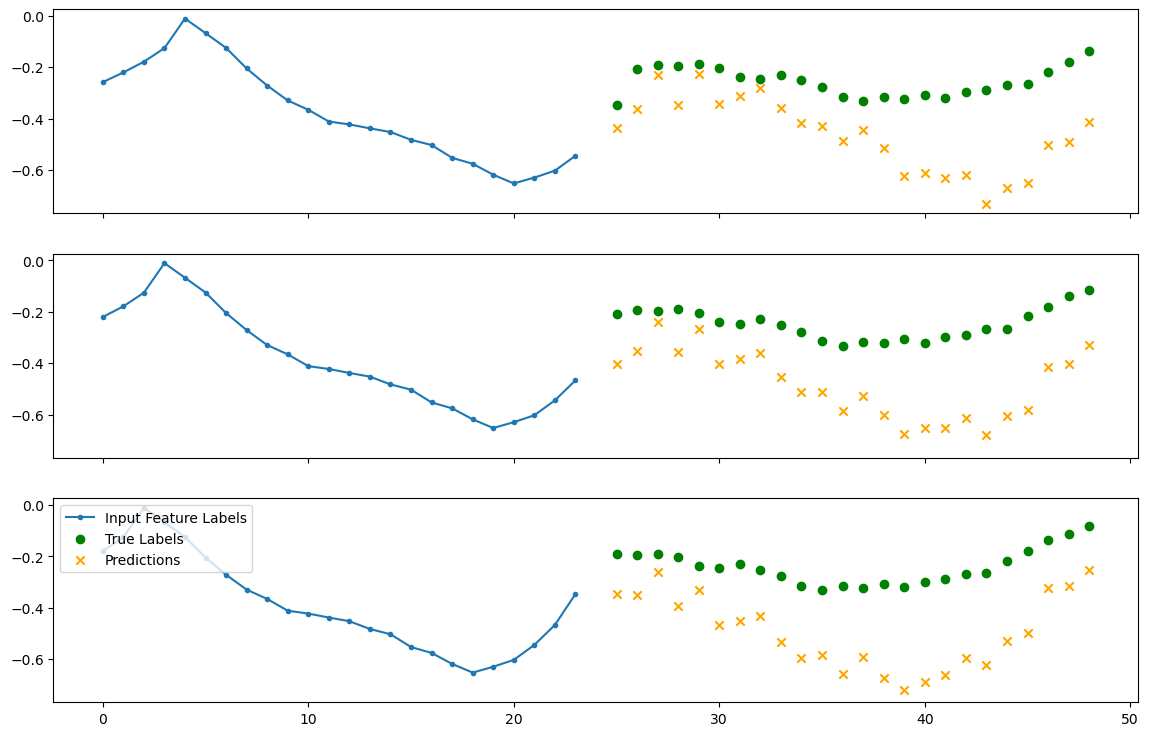

In [28]:
plot_windows(train_dataset, sample_input, sample_label, model=rnn_model, num_samples=3)

### Comparison

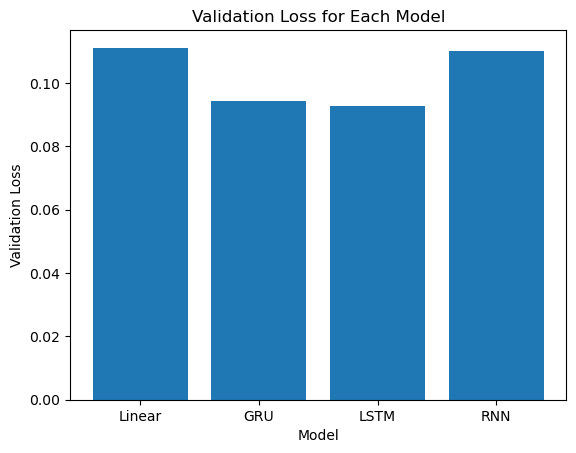

In [29]:
# Create a list of models
models = ["Linear", "GRU", "LSTM", "RNN"]

# Create a list of validation losses
val_losses = [lr_val_loss, gru_val_loss, lstm_val_loss, rnn_val_loss]

# Create the bar chart
plt.bar(models, val_losses)

# Add title and labels
plt.title("Validation Loss for Each Model")
plt.xlabel("Model")
plt.ylabel("Validation Loss")

# Show the plot
plt.show()

- The best model is the **LSTM** model. as it has the lowest MSE score on the validation set.

# LSTM Hyperparameter Tuning

In [30]:
def tunning(trial: optuna.Trial):
    lstm_model = LSTMModel(
        input_dim=N_FEATURES,
        hidden_dim=trial.suggest_int("hidden_dim", 32, 128, step=32),
        layer_dim=trial.suggest_int("layer_dim", 2, 4),
        output_dim=OUTPUT_SIZE,
    )

    # Decide the device to train on - cpu or gpu
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            lstm_model = nn.DataParallel(lstm_model)
    lstm_model.to(device)

    # Define the optimizer and the loss function
    optimizer = torch.optim.Adam(
        lstm_model.parameters(), lr=trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    )
    criterion = nn.MSELoss()

    # Create the train and validation dataloaders
    batch_size = trial.suggest_int("batch_size", 32, 128, step=32)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    # Training Loop
    for epoch in range(trial.suggest_int("epochs", 5, 20, step=5)):
        running_loss = 0.0
        lstm_model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            # Get the data and labels, transfer them to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # do the forward pass
            outputs = lstm_model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Clear the gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()

            # Calculate the gradients
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save the loss
            running_loss += loss.item()

        # Evaluation Loop
        lstm_model.eval()
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                # Load the data and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Do the forward pass
                outputs = lstm_model(inputs)

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Update the validation loss
                val_loss += loss.cpu().numpy()
                val_steps += 1

        trial.report(val_loss / val_steps, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_loss / val_steps

In [31]:
# Create an optuna study
study = optuna.create_study(direction="minimize")

# Start tunning
study.optimize(tunning, show_progress_bar=True, n_trials=33)

# get the best trial
best_trial = study.best_trial

# Print the params of the best trial
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2023-11-24 01:34:12,757] A new study created in memory with name: no-name-85bdf083-1fac-4f46-8183-70b06fb2f977
Best trial: 0. Best value: 0.428665:   3%|▎         | 1/33 [02:02<1:05:07, 122.10s/it]

[I 2023-11-24 01:36:14,866] Trial 0 finished with value: 0.4286646789007979 and parameters: {'hidden_dim': 96, 'layer_dim': 2, 'lr': 0.027499300203623674, 'batch_size': 32, 'epochs': 15}. Best is trial 0 with value: 0.4286646789007979.


Best trial: 1. Best value: 0.112234:   6%|▌         | 2/33 [03:10<46:52, 90.73s/it]   

[I 2023-11-24 01:37:23,633] Trial 1 finished with value: 0.1122342124354185 and parameters: {'hidden_dim': 64, 'layer_dim': 3, 'lr': 0.0005551175273480624, 'batch_size': 128, 'epochs': 20}. Best is trial 1 with value: 0.1122342124354185.


Best trial: 1. Best value: 0.112234:   9%|▉         | 3/33 [05:05<50:53, 101.78s/it]

[I 2023-11-24 01:39:18,556] Trial 2 finished with value: 0.8462400944056836 and parameters: {'hidden_dim': 128, 'layer_dim': 3, 'lr': 0.060902360718533284, 'batch_size': 96, 'epochs': 15}. Best is trial 1 with value: 0.1122342124354185.


Best trial: 3. Best value: 0.0918164:  12%|█▏        | 4/33 [07:28<56:56, 117.83s/it]

[I 2023-11-24 01:41:40,981] Trial 3 finished with value: 0.09181640029630878 and parameters: {'hidden_dim': 128, 'layer_dim': 4, 'lr': 0.00019480395823362375, 'batch_size': 96, 'epochs': 15}. Best is trial 3 with value: 0.09181640029630878.


Best trial: 3. Best value: 0.0918164:  15%|█▌        | 5/33 [08:41<47:28, 101.74s/it]

[I 2023-11-24 01:42:54,215] Trial 4 finished with value: 0.09999038341709159 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'lr': 0.0008696735539032071, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.09181640029630878.


Best trial: 3. Best value: 0.0918164:  18%|█▊        | 6/33 [08:45<30:46, 68.38s/it] 

[I 2023-11-24 01:42:57,817] Trial 5 pruned. 


Best trial: 3. Best value: 0.0918164:  21%|██        | 7/33 [10:18<33:14, 76.71s/it]

[I 2023-11-24 01:44:31,687] Trial 6 finished with value: 0.09560282511364032 and parameters: {'hidden_dim': 64, 'layer_dim': 3, 'lr': 0.0014031911180104129, 'batch_size': 64, 'epochs': 20}. Best is trial 3 with value: 0.09181640029630878.


Best trial: 3. Best value: 0.0918164:  24%|██▍       | 8/33 [10:26<22:44, 54.59s/it]

[I 2023-11-24 01:44:38,900] Trial 7 pruned. 


Best trial: 3. Best value: 0.0918164:  27%|██▋       | 9/33 [10:41<16:56, 42.36s/it]

[I 2023-11-24 01:44:54,367] Trial 8 pruned. 


Best trial: 3. Best value: 0.0918164:  30%|███       | 10/33 [12:04<21:04, 54.99s/it]

[I 2023-11-24 01:46:17,657] Trial 9 pruned. 


Best trial: 3. Best value: 0.0918164:  33%|███▎      | 11/33 [12:13<14:57, 40.79s/it]

[I 2023-11-24 01:46:26,231] Trial 10 pruned. 


Best trial: 3. Best value: 0.0918164:  36%|███▋      | 12/33 [12:18<10:27, 29.89s/it]

[I 2023-11-24 01:46:31,204] Trial 11 pruned. 


Best trial: 3. Best value: 0.0918164:  39%|███▉      | 13/33 [12:27<07:51, 23.55s/it]

[I 2023-11-24 01:46:40,169] Trial 12 pruned. 


Best trial: 3. Best value: 0.0918164:  42%|████▏     | 14/33 [12:32<05:40, 17.91s/it]

[I 2023-11-24 01:46:45,026] Trial 13 pruned. 


Best trial: 3. Best value: 0.0918164:  45%|████▌     | 15/33 [14:09<12:34, 41.93s/it]

[I 2023-11-24 01:48:22,636] Trial 14 pruned. 


Best trial: 15. Best value: 0.0834785:  48%|████▊     | 16/33 [16:10<18:33, 65.51s/it]

[I 2023-11-24 01:50:22,899] Trial 15 finished with value: 0.08347850930081999 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'lr': 0.0013492490601971288, 'batch_size': 32, 'epochs': 15}. Best is trial 15 with value: 0.08347850930081999.


Best trial: 15. Best value: 0.0834785:  52%|█████▏    | 17/33 [16:18<12:52, 48.27s/it]

[I 2023-11-24 01:50:31,080] Trial 16 pruned. 


Best trial: 15. Best value: 0.0834785:  55%|█████▍    | 18/33 [16:26<09:05, 36.37s/it]

[I 2023-11-24 01:50:39,737] Trial 17 pruned. 


Best trial: 15. Best value: 0.0834785:  58%|█████▊    | 19/33 [16:42<07:01, 30.10s/it]

[I 2023-11-24 01:50:55,254] Trial 18 pruned. 


Best trial: 15. Best value: 0.0834785:  61%|██████    | 20/33 [17:00<05:43, 26.45s/it]

[I 2023-11-24 01:51:13,188] Trial 19 pruned. 


Best trial: 15. Best value: 0.0834785:  64%|██████▎   | 21/33 [17:11<04:23, 21.98s/it]

[I 2023-11-24 01:51:24,752] Trial 20 pruned. 


Best trial: 15. Best value: 0.0834785:  67%|██████▋   | 22/33 [17:38<04:16, 23.28s/it]

[I 2023-11-24 01:51:51,048] Trial 21 pruned. 


Best trial: 15. Best value: 0.0834785:  70%|██████▉   | 23/33 [18:51<06:22, 38.29s/it]

[I 2023-11-24 01:53:04,340] Trial 22 finished with value: 0.08759173285216093 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'lr': 0.0006571316070453551, 'batch_size': 64, 'epochs': 15}. Best is trial 15 with value: 0.08347850930081999.


Best trial: 15. Best value: 0.0834785:  73%|███████▎  | 24/33 [18:55<04:12, 28.07s/it]

[I 2023-11-24 01:53:08,566] Trial 23 pruned. 


Best trial: 24. Best value: 0.0810202:  76%|███████▌  | 25/33 [21:07<07:53, 59.25s/it]

[I 2023-11-24 01:55:20,556] Trial 24 finished with value: 0.08102017173986518 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'lr': 0.00036936782596246206, 'batch_size': 32, 'epochs': 15}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202:  79%|███████▉  | 26/33 [23:24<09:38, 82.58s/it]

[I 2023-11-24 01:57:37,576] Trial 25 finished with value: 0.08221067916942625 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'lr': 0.00047126754484957007, 'batch_size': 32, 'epochs': 15}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202:  82%|████████▏ | 27/33 [24:53<08:26, 84.48s/it]

[I 2023-11-24 01:59:06,479] Trial 26 finished with value: 0.08171493863323476 and parameters: {'hidden_dim': 32, 'layer_dim': 2, 'lr': 0.00045622397405592144, 'batch_size': 32, 'epochs': 10}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202:  85%|████████▍ | 28/33 [25:37<06:01, 72.24s/it]

[I 2023-11-24 01:59:50,166] Trial 27 finished with value: 0.08950540879968463 and parameters: {'hidden_dim': 32, 'layer_dim': 2, 'lr': 0.00039933720430191446, 'batch_size': 32, 'epochs': 5}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202:  88%|████████▊ | 29/33 [27:02<05:04, 76.24s/it]

[I 2023-11-24 02:01:15,727] Trial 28 finished with value: 0.08602448974497526 and parameters: {'hidden_dim': 32, 'layer_dim': 2, 'lr': 0.0004382185487501009, 'batch_size': 32, 'epochs': 10}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202:  91%|█████████ | 30/33 [28:31<03:59, 79.78s/it]

[I 2023-11-24 02:02:43,776] Trial 29 finished with value: 0.08521562653434712 and parameters: {'hidden_dim': 32, 'layer_dim': 2, 'lr': 0.0002180306122018609, 'batch_size': 32, 'epochs': 10}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202:  94%|█████████▍| 31/33 [30:04<02:47, 83.99s/it]

[I 2023-11-24 02:04:17,593] Trial 30 finished with value: 0.08431143558402432 and parameters: {'hidden_dim': 64, 'layer_dim': 2, 'lr': 0.0007825113374453894, 'batch_size': 32, 'epochs': 10}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202:  97%|█████████▋| 32/33 [32:35<01:44, 104.12s/it]

[I 2023-11-24 02:06:48,519] Trial 31 finished with value: 0.08269363737710547 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'lr': 0.0004937461481213865, 'batch_size': 32, 'epochs': 15}. Best is trial 24 with value: 0.08102017173986518.


Best trial: 24. Best value: 0.0810202: 100%|██████████| 33/33 [32:51<00:00, 59.74s/it] 

[I 2023-11-24 02:07:04,225] Trial 32 pruned. 
  Params: 
    hidden_dim: 32
    layer_dim: 3
    lr: 0.00036936782596246206
    batch_size: 32
    epochs: 15


# Testing 

In [32]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=best_trial.params["batch_size"],
    shuffle=False,
)

In [33]:
# Create a new LSTM model with the best trial params
lstm_model = LSTMModel(
    input_dim=N_FEATURES,
    hidden_dim=best_trial.params["hidden_dim"],
    layer_dim=best_trial.params["layer_dim"],
    output_dim=OUTPUT_SIZE,
)

In [34]:
# Train the model on the entire training data
train_model(
    lstm_model,
    train_dataloader,
    nn.MSELoss,
    torch.optim.Adam,
    lr=best_trial.params["lr"],
    num_epochs=best_trial.params["epochs"],
)

/home/mmostafa/miniconda3/envs/aienv10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 0.034274984151124954
Epoch: 1, Loss: 0.039490390568971634
Epoch: 2, Loss: 0.03456410393118858
Epoch: 3, Loss: 0.031910862773656845
Epoch: 4, Loss: 0.03334621712565422
Epoch: 5, Loss: 0.035419244319200516
Epoch: 6, Loss: 0.035275597125291824
Epoch: 7, Loss: 0.041734810918569565
Epoch: 8, Loss: 0.032439060509204865
Epoch: 9, Loss: 0.03953355923295021
Epoch: 10, Loss: 0.033488716930150986
Epoch: 11, Loss: 0.0403372086584568
Epoch: 12, Loss: 0.03544846549630165
Epoch: 13, Loss: 0.03598547354340553
Epoch: 14, Loss: 0.04490664228796959


In [35]:
# Evaluate the model on the test set
test_loss, sample_input, sample_label = evaluate_model(
    lstm_model, test_dataloader, nn.MSELoss
)
test_loss

0.25904103754678875